Importing the required libraries and constants

In [2]:
import os, pathlib, json, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score

SEED = 42
IMG_SIZE = (224, 224)
BATCH = 32

ROOT_DIR = pathlib.Path("data/")
TRAIN_DIR = ROOT_DIR / "training"
VAL_DIR   = ROOT_DIR / "validation"
MODEL_DIR = "models"

This file is for training the various image classification models

In [4]:
import pathlib, tensorflow as tf
from tensorflow import keras

# Build datasets WITHOUT validation_split
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False   # keep order stable for metrics/plots
)

# Class names (e.g., ['01-minor','02-moderate','03-severe'])
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# (Optional) pretty labels for display, stripping the numeric prefixes
pretty_names = [c.split('-', 1)[-1] if '-' in c else c for c in class_names]

AUTOTUNE = tf.data.AUTOTUNE
def configure(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = configure(train_ds, training=True)
val_ds   = configure(val_ds)

Found 1364 files belonging to 3 classes.
Found 248 files belonging to 3 classes.
Classes: ['01-minor', '02-moderate', '03-severe']


Setting up F1 function for performance evaluation

In [7]:
import numpy as np
from sklearn.metrics import f1_score

class MacroF1Callback(keras.callbacks.Callback):
    def __init__(self, val_ds, num_classes):
        super().__init__()
        self.val_ds = val_ds
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for xb, yb in self.val_ds:
            probs = self.model.predict(xb, verbose=0)
            y_pred.extend(np.argmax(probs, axis=1))
            # yb may be ints or one-hot depending on your pipeline:
            if yb.ndim == 2:  # one-hot
                y_true.extend(np.argmax(yb.numpy(), axis=1))
            else:             # integer labels
                y_true.extend(yb.numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        logs = logs or {}
        logs["val_macro_f1"] = macro_f1
        print(f"\nval_macro_f1: {macro_f1:.4f}")

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

preprocess = keras.applications.efficientnet_v2.preprocess_input

base = keras.applications.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3)
)
base.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,923,155 (22.60 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 5. Training with Checkpoint

Early stopping with checkpoint. we start with frozen and then unlock the model. GPU enabled runtime will run much faster. If you plot the curves what can it tell you on the epochs?

In [ ]:
EPOCHS_FROZEN = 8
EPOCHS_FINE   = 12

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

# If your datasets are integer labels, map to one-hot for this loss:
train_oh = train_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))
val_oh   = val_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

f1_cb = MacroF1Callback(val_ds, NUM_CLASSES)

#Model filename
filename = MODEL_DIR + "\\best_frozen.keras"

ckpt1 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)
early = keras.callbacks.EarlyStopping(monitor="val_macro_f1", mode="max",
                                      patience=5, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)

hist1 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FROZEN, callbacks=[f1_cb, ckpt1, early, reduce], verbose=2
)

Epoch 1/8

val_macro_f1: 0.4427

Epoch 1: val_macro_f1 improved from None to 0.44269, saving model to best_frozen.keras
43/43 - 71s - 2s/step - acc: 0.3930 - loss: 1.1053 - val_acc: 0.4597 - val_loss: 1.0086 - val_macro_f1: 0.4427 - learning_rate: 3.0000e-04
Epoch 2/8

val_macro_f1: 0.5865

Epoch 2: val_macro_f1 improved from 0.44269 to 0.58647, saving model to best_frozen.keras
43/43 - 55s - 1s/step - acc: 0.5139 - loss: 0.9849 - val_acc: 0.5927 - val_loss: 0.9045 - val_macro_f1: 0.5865 - learning_rate: 3.0000e-04
Epoch 3/8

val_macro_f1: 0.6340

Epoch 3: val_macro_f1 improved from 0.58647 to 0.63400, saving model to best_frozen.keras
43/43 - 46s - 1s/step - acc: 0.5403 - loss: 0.9484 - val_acc: 0.6371 - val_loss: 0.8617 - val_macro_f1: 0.6340 - learning_rate: 3.0000e-04
Epoch 4/8

val_macro_f1: 0.6479

Epoch 4: val_macro_f1 improved from 0.63400 to 0.64794, saving model to best_frozen.keras
43/43 - 39s - 916ms/step - acc: 0.5491 - loss: 0.9178 - val_acc: 0.6532 - val_loss: 0.8297 - v

6. Unfreeze (Fine Tuning)

In [ ]:
# Unfreeze top layers except BatchNorm
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

filename = MODEL_DIR + "\\best_finetuned.keras"
f1_cb2 = MacroF1Callback(val_ds, NUM_CLASSES)
ckpt2 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)

hist2 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FINE, callbacks=[f1_cb2, ckpt2, early, reduce], verbose=2
)

Epoch 1/12

val_macro_f1: 0.6959

Epoch 1: val_macro_f1 improved from None to 0.69587, saving model to best_finetuned.keras
43/43 - 55s - 1s/step - acc: 0.6188 - loss: 0.8328 - val_acc: 0.6976 - val_loss: 0.7406 - val_macro_f1: 0.6959 - learning_rate: 1.0000e-05
Epoch 2/12

val_macro_f1: 0.7003

Epoch 2: val_macro_f1 improved from 0.69587 to 0.70025, saving model to best_finetuned.keras
43/43 - 54s - 1s/step - acc: 0.6298 - loss: 0.8306 - val_acc: 0.7016 - val_loss: 0.7315 - val_macro_f1: 0.7003 - learning_rate: 1.0000e-05
Epoch 3/12

val_macro_f1: 0.7091

Epoch 3: val_macro_f1 improved from 0.70025 to 0.70908, saving model to best_finetuned.keras
43/43 - 52s - 1s/step - acc: 0.6554 - loss: 0.8051 - val_acc: 0.7097 - val_loss: 0.7237 - val_macro_f1: 0.7091 - learning_rate: 1.0000e-05
Epoch 4/12

val_macro_f1: 0.7206

Epoch 4: val_macro_f1 improved from 0.70908 to 0.72061, saving model to best_finetuned.keras
43/43 - 55s - 1s/step - acc: 0.6635 - loss: 0.8058 - val_acc: 0.7218 - val_los

7. Performance Evaluation
there are also other things to show. can you think of any?

Confusion matrix:
 [[69 12  1]
 [13 51 11]
 [ 2 26 63]]

Classification report:
              precision    recall  f1-score   support

    01-minor       0.82      0.84      0.83        82
 02-moderate       0.57      0.68      0.62        75
   03-severe       0.84      0.69      0.76        91

    accuracy                           0.74       248
   macro avg       0.74      0.74      0.74       248
weighted avg       0.75      0.74      0.74       248

Macro-F1: 0.7374375550984426
Found 3124 files belonging to 4 classes.
Using 312 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


IndexError: list index out of range

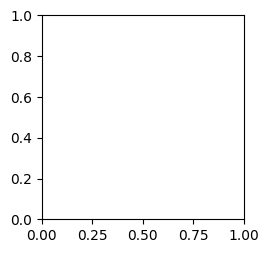

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
MODEL_FILE = MODEL_DIR + "\\best_finetuned.keras"

best = keras.models.load_model(MODEL_FILE, compile=False)
best.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = best.predict(xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    if yb.ndim == 2: y_true.extend(np.argmax(yb.numpy(), axis=1))
    else:            y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))


In [ ]:
import matplotlib.pyplot as plt
import random
MODEL_FILE = MODEL_DIR + "\\best_finetuned.keras"

# Create a dataset with raw images and labels (no one-hot)
val_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="validation",
    shuffle=True
)

# Get a small batch
images, labels = next(iter(val_raw))
pred_probs = best.predict(images)
pred_ids = np.argmax(pred_probs, axis=1)
true_ids = labels.numpy()

# Plot 12 random samples
plt.figure(figsize=(12, 9))
for i, idx in enumerate(random.sample(range(len(images)), 12)):
    ax = plt.subplot(3, 4, i + 1)
    img = images[idx].numpy().astype("uint8")
    true_label = class_names[true_ids[idx]]
    pred_label = class_names[pred_ids[idx]]
    color = "green" if pred_label == true_label else "red"
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()